## Data preprocessing 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def standardization(df, cols):
    scaler = StandardScaler()
    df[cols] = scaler.fit_transform(df[cols])

def data_prep():
    # Read txt
    train_df = pd.read_csv('traininingdata.txt', sep=";")
    test_df = pd.read_csv('testdata.txt', sep=";")

    # Find 3 kinds of attributes
    numeric_var = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
    binary_var = ['default', 'housing', 'loan', 'y']
    categorical_var = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']

    # Replace the pdays -1 with maximized pdays
    max_pdays_train = max(train_df['pdays'])
    max_pdays_test = max(test_df['pdays'])
    max_pdays = max(max_pdays_train, max_pdays_test)
    train_df['pdays'] = train_df['pdays'].replace({-1: max_pdays})
    test_df['pdays'] = test_df['pdays'].replace({-1: max_pdays})

    # Replace labels Yes and No with 1 and 0
    train_df = train_df.replace({'yes': 1, 'no': 0})
    test_df = test_df.replace({'yes': 1, 'no': 0})

    # Split data to train and test parts
    x_train = train_df.iloc[:, :-1]
    y_train = train_df.iloc[:, -1]
    x_test = test_df.iloc[:, :-1]
    y_test = test_df.iloc[:, -1]

    # Transfrom categorical attributes with one-hot encoding 
    x_train = pd.get_dummies(x_train)
    x_test = pd.get_dummies(x_test)
    # Find the columns that in x_train but not in x_test
    missing_cols = set(x_train.columns) - set(x_test.columns)
    for c in missing_cols:
        x_test[c] = 0
    # Ensure the column order of x_train and x_test are the same
    x_test = x_test[x_train.columns]

    # Standarize numerical attributes
    standardization(x_train, numeric_var)
    standardization(x_test, numeric_var)

    return x_train, y_train, x_test, y_test

if __name__ == "__main__":
    x_train, y_train, x_test, y_test = data_prep()
    print(x_train.shape)

(36168, 48)


## Logistic Regression

In [2]:
x_train, y_train, x_test, y_test = data_prep()

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef
from sklearn import metrics
import seaborn as sns

Here we define some reusable functions for hyper-parameter tuning:

In [4]:
# visualize the GridSearchCV results
def visualize_cv(best_clf, score, num):
    # create a df storing model scores ordered by performance
    results_df = pd.DataFrame(best_clf.cv_results_)
    results_df = results_df.sort_values(by=["rank_test_score"])[:num]
    results_df = results_df.set_index(
        results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
    ).rename_axis("kernel")
    results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

    # 1. plot top 'num' models between each cv fold and scores  
    model_split_scores = results_df.filter(regex=r"split\d*_test_score")
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    sns.lineplot(
        data=model_split_scores.transpose(),
        dashes=False,
        palette="Set1",
        marker="o",
        alpha=0.5,
        ax=ax[0],
    )
    ax[0].set_xlabel("CV test fold", size=12, labelpad=10)
    ax[0].set_ylabel(f"Model {score} Score", size=12)
    
    # 2. plot avg test score to each params combination
    model_test_score = results_df.filter(regex="mean_test_score")
    print(model_test_score)
    sns.lineplot(
        data=model_test_score,
        dashes=False,
        palette="Set1",
        marker="o",
        alpha=0.5,
        ax=ax[1],
    )
    ax[1].set_xlabel("Params", size=12, labelpad=10)
    ax[1].set_ylabel(f"Mean model {score} Score", size=12)
    ax[1].tick_params(labelrotation=25)
    plt.show()
    
    return results_df
    

In [5]:
# grid search for finding hyper parameters
import warnings
def find_best_estimator(x_train, y_train, score):
    ## find best estimators on new training dataset
    warnings.filterwarnings("ignore")
    
    print(x_train.shape)

    params = {'C':[0.01, 0.1, 1, 10, 100],
              'max_iter':[1, 10, 100, 1000],
              'class_weight':['balanced', None],
              'solver':['liblinear','sag','lbfgs','newton-cg'],
            }
    lr_test = LogisticRegression()
    best_clf = GridSearchCV(lr_test, param_grid=params, verbose=1, scoring=score)
    best_clf.fit(x_train,y_train)
    print(best_clf.best_params_)
    return best_clf

In [23]:
# test models with top parameters and plot results
def test_models(top_params, x_train, y_train, x_test, y_test):
    f1_scores_list = {}
    for param in top_params:
        C = param['C']
        class_weight = param['class_weight']
        max_iter = param['max_iter']
        solver = param['solver']
        
        LR_clf = LogisticRegression(random_state=0, C=C, class_weight=class_weight, solver=solver, max_iter=max_iter)
        LR_clf.fit(x_train, y_train)
        y_pred = LR_clf.predict(x_test)

        cm = confusion_matrix(y_test,y_pred)
        TP = cm[1,1]
        FP = cm[1,0]
        FN = cm[0,1]
        TN = cm[0,0]
        accuracy = (TP+TN)/np.sum(cm)
        precision = TP/(TP+FP)
        recall = TP/(TP+FN)
        F1 = (2 * precision * recall)/(precision + recall)
        f1_scores_list[f'{C}_{class_weight}_{max_iter}_{solver}'] = [F1]
    
    tmp_df = pd.DataFrame(f1_scores_list)
    tmp_df.index = ['Test F1 score']
    test_results_df = tmp_df.transpose().rename_axis("kernel").sort_values(by=["Test F1 score"], ascending=False)
    print(test_results_df)
    
    fig, ax = plt.subplots()
    sns.lineplot(
        data=test_results_df,
        dashes=False,
        palette="Set1",
        marker="o",
        alpha=0.5,
        ax=ax,
    )
    ax.set_xlabel("Params", size=12, labelpad=10)
    ax.set_ylabel(f"Test F1 Score", size=12)
    ax.tick_params(labelrotation=25)
    plt.show()

**Find optimized hyper-parameters(Metric: F1):**

In [7]:
import warnings
warnings.filterwarnings("ignore")

params = {'C':[0.01, 0.1, 1, 10, 100],
          'max_iter':[1, 10, 100, 1000],
          'class_weight':['balanced', None],
          'solver':['liblinear','sag','lbfgs','newton-cg'],
        }
lr_test = LogisticRegression()
best_clf = GridSearchCV(lr_test, param_grid=params, verbose=1, scoring='f1')
best_clf.fit(x_train,y_train)
best_clf.best_params_

Fitting 5 folds for each of 160 candidates, totalling 800 fits


{'C': 10, 'class_weight': 'balanced', 'max_iter': 100, 'solver': 'sag'}

                           mean_test_score
kernel                                    
10_balanced_100_sag               0.551715
100_balanced_100_sag              0.551671
1_balanced_100_sag                0.551623
1_balanced_1000_newton-cg         0.551535
1_balanced_100_newton-cg          0.551535
1_balanced_1000_lbfgs             0.551535
1_balanced_1000_liblinear         0.551535
1_balanced_10_liblinear           0.551535


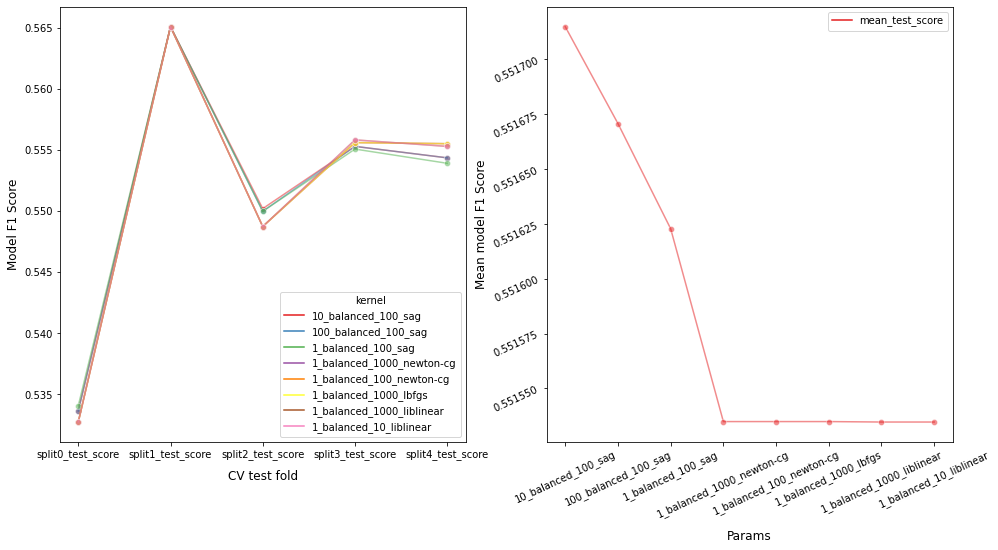

In [12]:
# plot result of grid search
result_df = visualize_cv(best_clf, 'F1', 8)

                           Test F1 score
kernel                                  
10_balanced_100_sag             0.551020
100_balanced_100_sag            0.551020
1_balanced_100_sag              0.550669
1_balanced_1000_newton-cg       0.550096
1_balanced_100_newton-cg        0.550096
1_balanced_1000_lbfgs           0.550096
1_balanced_1000_liblinear       0.550096
1_balanced_10_liblinear         0.550096


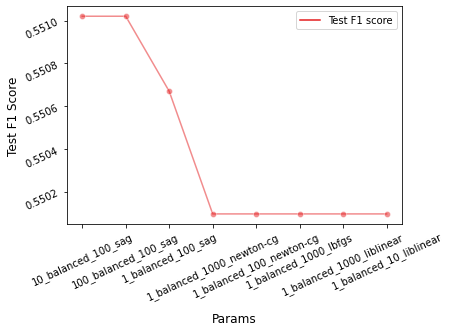

In [24]:
## test models with top 8 parameters
top_params = result_df['params']
test_models(top_params, x_train, y_train, x_test, y_test)

------LogisticRegression (Metric: f1)------
C           : 10
class-weight: balanced
Max_iter    : 100
Solver      : sag
Test Results:
Accuracy : 0.8441888753732169
Precision: 0.8166351606805293
Recall   : 0.4155844155844156
MMC      : 0.5075773366618478
F1 score : 0.5508447561364361


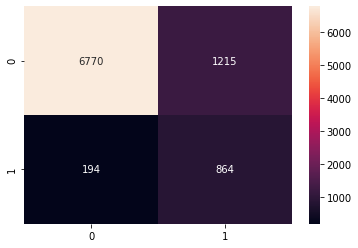

In [22]:
## test: 10 'balanced' 100 'sag' -- 0.55102
random_state=0
C_best = best_clf.best_params_['C']
class_weight_best = best_clf.best_params_['class_weight']
max_iter_best = best_clf.best_params_['max_iter']
solver_best = best_clf.best_params_['solver']

LR_best_model = best_clf.best_estimator_
y_pred = LR_best_model.predict(x_test)

# print(metrics.f1_score(y_test, y_pred))
cm = confusion_matrix(y_test,y_pred)
TP = cm[1,1]
FP = cm[1,0]
FN = cm[0,1]
TN = cm[0,0]
accuracy = (TP+TN)/np.sum(cm)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1 = (2 * precision * recall)/(precision + recall)

sns.heatmap(cm, annot=True, fmt="d")
print('------LogisticRegression (Metric: f1)------')
print(f'C           : {C_best}')
print(f'class-weight: {class_weight_best}')
print(f'Max_iter    : {max_iter_best}')
print(f'Solver      : {solver_best}')
print('Test Results:')
print(f'Accuracy : {accuracy}')
print(f'Precision: {precision}')
print(f'Recall   : {recall}')
print(f'MMC      : {matthews_corrcoef(y_test, y_pred)}')
print(f'F1 score : {F1}')

## Test with oversampling

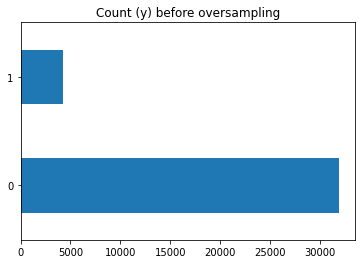

In [7]:
# 'y' is extremly imbalanced
target_count = y_train.value_counts()
target_count.plot(kind='barh', title='Count (y) before oversampling');

In [8]:
# apply over-sampling functions
from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE(random_state=123)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

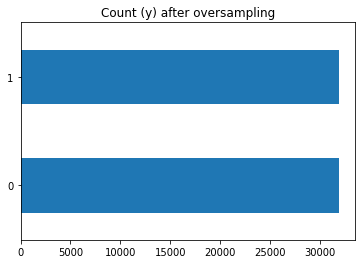

In [9]:
target_count = y_train_res.value_counts()
target_count.plot(kind='barh', title='Count (y) after oversampling');

In [10]:
## find best estimators on new training dataset
import warnings

## search for best estimator
warnings.filterwarnings("ignore")

params = {'C':[0.01, 0.1, 1, 10, 100],
          'max_iter':[1, 10, 100, 1000],
          'class_weight':['balanced', None],
          'solver':['liblinear','sag','lbfgs','newton-cg'],
        }
lr_test = LogisticRegression()
best_clf = GridSearchCV(lr_test, param_grid=params, verbose=1, scoring='f1')
# use resampled data
best_clf.fit(x_train_res,y_train_res)
best_clf.best_params_

Fitting 5 folds for each of 160 candidates, totalling 800 fits


{'C': 10, 'class_weight': None, 'max_iter': 1000, 'solver': 'sag'}

                        mean_test_score
kernel                                 
10_None_1000_sag               0.910745
10_balanced_1000_sag           0.910707
100_None_1000_sag              0.910703
100_balanced_1000_sag          0.910703
1_balanced_1000_sag            0.910575
1_None_1000_sag                0.910559
10_None_100_newton-cg          0.910492
10_None_1000_newton-cg         0.910492


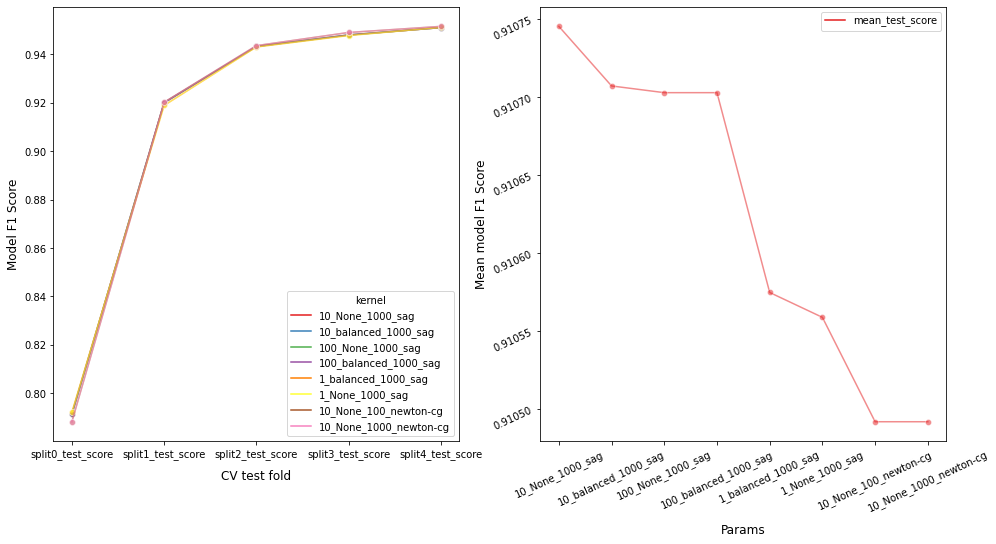

In [11]:
# plot results
result_df = visualize_cv(best_clf, 'F1', 8)

                        Test F1 score
kernel                               
10_None_1000_sag             0.582404
10_balanced_1000_sag         0.582404
1_None_1000_sag              0.582268
1_balanced_1000_sag          0.582268
100_None_1000_sag            0.581818
100_balanced_1000_sag        0.581818
10_None_100_newton-cg        0.579385
10_None_1000_newton-cg       0.579385


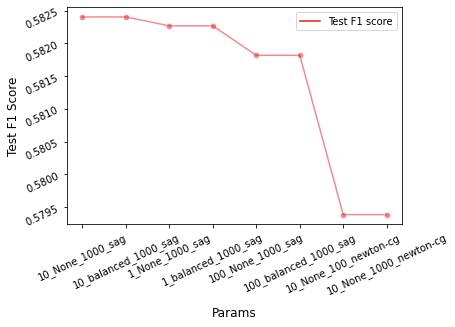

In [18]:
## test models with top 8 parameters
top_params = result_df['params']
test_models(top_params, x_train_res, y_train_res, x_test, y_test)

------LogisticRegression Oversampling (Metric: f1)------
C           : 10
class-weight: None
Max_iter    : 1000
Solver      : sag
Test Results:
Accuracy : 0.8882008183125069
Precision: 0.666351606805293
Recall   : 0.5172413793103449
MMC      : 0.5245963455930702
F1 score : 0.5824039653035935


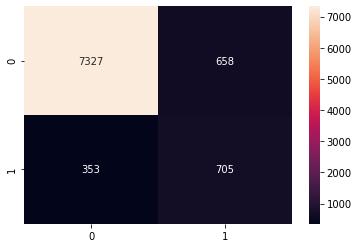

In [12]:
## test1: 10 None 1000 'sag' -- 0.582404
C_best = best_clf.best_params_['C']
class_weight_best = best_clf.best_params_['class_weight']
max_iter_best = best_clf.best_params_['max_iter']
solver_best = best_clf.best_params_['solver']

# LR_clf = LogisticRegression(random_state=0, C=C_best, class_weight=class_weight_best, solver=solver_best, max_iter=max_iter_best)
# LR_clf.fit(x_train, y_train)
LR_best_model = best_clf.best_estimator_
y_pred = LR_best_model.predict(x_test)
# print(metrics.f1_score(y_test, y_pred))

cm = confusion_matrix(y_test,y_pred)
TP = cm[1,1]
FP = cm[1,0]
FN = cm[0,1]
TN = cm[0,0]
accuracy = (TP+TN)/np.sum(cm)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1 = (2 * precision * recall)/(precision + recall)

sns.heatmap(cm, annot=True, fmt="d")
print('------LogisticRegression Oversampling (Metric: f1)------')
print(f'C           : {C_best}')
print(f'class-weight: {class_weight_best}')
print(f'Max_iter    : {max_iter_best}')
print(f'Solver      : {solver_best}')
print('Test Results:')
print(f'Accuracy : {accuracy}')
print(f'Precision: {precision}')
print(f'Recall   : {recall}')
print(f'MMC      : {matthews_corrcoef(y_test, y_pred)}')
print(f'F1 score : {F1}')

## Feature Engineering 

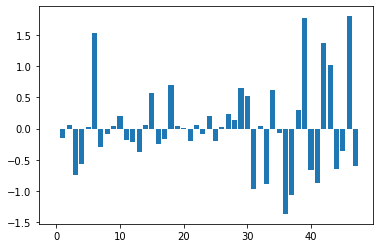

In [25]:
## feature coefficients of all 48 features
coefficients = LR_best_model.coef_[0]
feature_importances = pd.Series(coefficients, index=x_test.columns)

# plot feature coefficient
plt.bar([x for x in range(len(coefficients))], coefficients)
plt.show()

In [27]:
# 10 most important features
abs_importances = np.abs(feature_importances)
n_largest_idxes = abs_importances.nlargest(10).index
n_largest_importances = feature_importances[n_largest_idxes]
n_largest_importances

poutcome_success    1.795773
month_mar           1.762582
duration            1.523164
month_jan          -1.362938
month_oct           1.361696
month_jul          -1.061020
month_sep           1.015250
contact_unknown    -0.972103
month_aug          -0.886019
month_nov          -0.872972
dtype: float64

In [60]:
# n least important features
abs_importances = np.abs(feature_importances)
n_least_idxes = abs_importances.nsmallest(2).index
n_least_importances = feature_importances[n_least_idxes]
n_least_importances

job_unemployed    0.008810
age              -0.012642
dtype: float64

In [51]:
# removing n least important features from original data
x_train_remain = x_train.drop(n_least_idxes, axis=1)
x_test_remain = x_test.drop(n_least_idxes, axis=1)

In [52]:
# grid search for hyper-parameters
best_clf = find_best_estimator(x_train_remain, y_train, 'f1')

(36168, 46)
Fitting 5 folds for each of 160 candidates, totalling 800 fits
{'C': 1, 'class_weight': 'balanced', 'max_iter': 100, 'solver': 'sag'}


                             mean_test_score
kernel                                      
1_balanced_100_sag                  0.552274
10_balanced_100_sag                 0.552155
1_balanced_10_newton-cg             0.552063
10_balanced_1000_liblinear          0.552018
100_balanced_1000_liblinear         0.552018
100_balanced_100_liblinear          0.552018
100_balanced_10_liblinear           0.552018
10_balanced_1000_newton-cg          0.552018


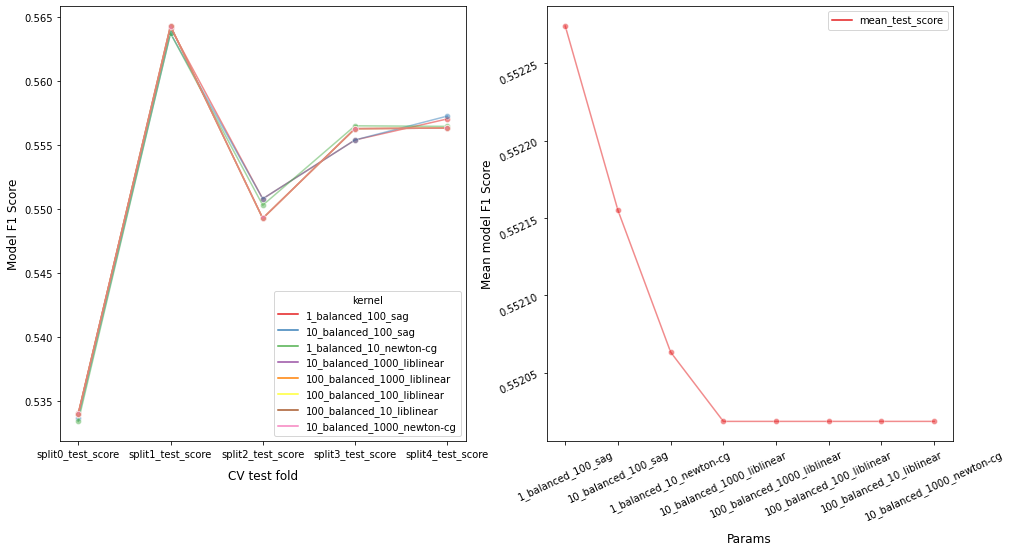

In [53]:
# plot results of grid search
result_df = visualize_cv(best_clf, 'F1', 8)

                             Test F1 score
kernel                                    
1_balanced_10_newton-cg           0.550160
1_balanced_100_sag                0.549857
10_balanced_100_sag               0.549857
10_balanced_1000_liblinear        0.549633
100_balanced_1000_liblinear       0.549633
100_balanced_100_liblinear        0.549633
100_balanced_10_liblinear         0.549633
10_balanced_1000_newton-cg        0.549633


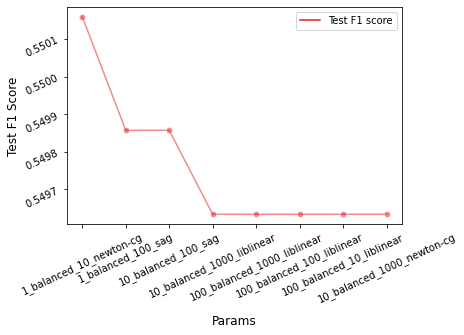

In [54]:
## test models with top 8 parameters
top_params = result_df['params']
test_models(top_params, x_train_remain, y_train, x_test_remain, y_test)

------LogisticRegression Feature Selection (Metric: f1)------
C           : 1
class-weight: balanced
Max_iter    : 100
Solver      : sag
Test Results:
Accuracy : 0.8437465442883999
Precision: 0.8156899810964083
Recall   : 0.4147044690052859
MMC      : 0.5063975809338581
F1 score : 0.5498566422427525


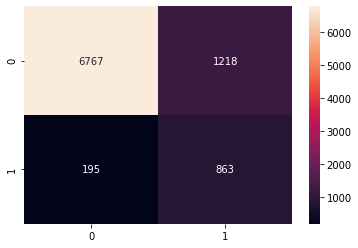

In [56]:
## test: 1 balanced 10 'newton-cg' -- 0.550160
## given best estimator: 1_balanced_100_sag

C_best = 1 # best_clf.best_params_['C']
class_weight_best = 'balanced' #best_clf.best_params_['class_weight']
max_iter_best = 10 # best_clf.best_params_['max_iter']
solver_best = 'newton-cg' # best_clf.best_params_['solver']
# LR_clf = LogisticRegression(random_state=0, C=C_best, class_weight=class_weight_best, solver=solver_best, max_iter=max_iter_best)
# LR_clf.fit(x_train_remain, y_train)
# y_pred = LR_clf.predict(x_test_remain)

LR_best_model = best_clf.best_estimator_
y_pred = LR_best_model.predict(x_test_remain)

# print(metrics.f1_score(y_test, y_pred))
cm = confusion_matrix(y_test,y_pred)
TP = cm[1,1]
FP = cm[1,0]
FN = cm[0,1]
TN = cm[0,0]
accuracy = (TP+TN)/np.sum(cm)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1 = (2 * precision * recall)/(precision + recall)

sns.heatmap(cm, annot=True, fmt="d")
print('------LogisticRegression Feature Selection (Metric: f1)------')
print(f'C           : {C_best}')
print(f'class-weight: {class_weight_best}')
print(f'Max_iter    : {max_iter_best}')
print(f'Solver      : {solver_best}')
print('Test Results:')
print(f'Accuracy : {accuracy}')
print(f'Precision: {precision}')
print(f'Recall   : {recall}')
print(f'MMC      : {matthews_corrcoef(y_test, y_pred)}')
print(f'F1 score : {F1}')